# Solutions for Assignment 5: Exploring Yelp Reviews in Philadelphia

In this assignment, we'll explore restaurant review data available through the [Yelp Dataset Challenge](https://www.yelp.com/dataset). The dataset includes Yelp data for user reviews and business information for many metropolitan areas. I've already downloaded this dataset (8 GB total!) and extracted out the data files for reviews and restaurants in Philadelphia. I've placed these data files into the `data` directory in this repository. 

This assignment is broken into two parts:

**Part 1:** Analyzing correlations between restaurant reviews and census data

We'll explore the relationship between restaurant reviews and the income levels of the restaurant's surrounding area.

**Part 2:** Exploring the impact of fast food restaurants

We'll run a sentiment analysis on reviews of fast food restaurants and estimate income levels in neighborhoods with fast food restaurants. We'll test how well our sentiment analysis works by comparing the number of stars to the sentiment of reviews.


**Background readings**
- [Does sentiment analysis work?](http://varianceexplained.org/r/yelp-sentiment/)
- [The Geography of Taste: Using Yelp to Study Urban Culture](https://www.mdpi.com/2220-9964/7/9/376/pdf/1)

## 1. Correlating restaurant ratings and income levels

In this part, we'll use the census API to download household income data and explore how it correlates with restaurant review data.

### 1.1 Query the Census API

Use the `cenpy` package to download **median household income in the past 12 months** by census tract from the 2021 ACS 5-year data set for your county of interest.

You have two options to find the correct variable names:
- Search through: [https://api.census.gov/data/2021/acs/acs5/variables.html](https://api.census.gov/data/2021/acs/acs5/variables.html)
- Initialize an API connection and use the `.varslike()` function to search for the proper keywords 

At the end of this step, you should have a pandas DataFrame holding the income data for all census tracts within the county being analyzed. Feel free to rename your variable from the ACS so it has a more meaningful name!

::: {.callout-caution}
Some census tracts won't have any value because there are not enough households in that tract. The census will use a negative number as a default value for those tracts. You can safely remove those tracts from the analysis!
:::

In [13]:
import cenpy
import pandas as pd
import pygris
from pygris import tracts
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns

In [14]:
acs = cenpy.remote.APIConnection("ACSDT5Y2021")

variables = ['B19013_001E']

phl_data = acs.query(
    variables,
    geo_unit="tract:*",
    geo_filter={"state": '42', "county": '101'},
)

phl_data = phl_data[phl_data['B19013_001E'].astype(float) > 0]

### 1.2 Download census tracts from the Census and merge the data from part 1.1

- Download census tracts for the desired geography using the `pygris` package
- Merge the downloaded census tracts with the household income DataFrame

In [15]:
phl_block_groups = tracts(state = "PA", county='Philadelphia', cb = True)

merged = phl_block_groups.merge(phl_data,left_on='TRACTCE',right_on='tract').to_crs('EPSG:4326')

Using the default year of 2021
Using FIPS code '42' for input 'PA'
Using FIPS code '101' for input 'Philadelphia'


### 1.3 Load the restaurants data

The Yelp dataset includes data for 7,350 restaurants across the city. Load the data from the `data/` folder and use the `latitude` and `longitude` columns to create a GeoDataFrame after loading the JSON data. Be sure to set the right CRS on when initializing the GeoDataFrame!

**Notes**

The JSON data is in a "records" format. To load it, you'll need to pass the following keywords: 

- `orient='records'`
- `lines=True`

In [16]:
restaurants = pd.read_json('.\\data\\restaurants_philly\\restaurants_philly.json',orient='records',lines=True)

restaurants_gpd = gpd.GeoDataFrame(restaurants, geometry = gpd.points_from_xy(restaurants['longitude'],restaurants['latitude']),crs='EPSG:4326')

### 1.4 Add tract info for each restaurant

Do a spatial join to identify which census tract each restaurant is within. Make sure each dataframe has the same CRS!

At the end of this step, you should have a new dataframe with a column identifying the tract number for each restaurant.

In [17]:
restaurant_join = gpd.sjoin(restaurants_gpd,merged, how='inner', predicate='intersects')
restaurant_join['B19013_001E'] = restaurant_join['B19013_001E'].astype(float)

### 1.6 Make a plot of median household income vs. Yelp stars

Our dataset has the number of stars for each restaurant, rounded to the nearest 0.5 star. In this step, create a line plot that shows the average income value for each stars category (e.g., all restaurants with 1 star, 1.5 stars, 2 stars, etc.)

While their are multiple ways to do this, the [seaborn.lineplot()](https://seaborn.pydata.org/generated/seaborn.lineplot.html) is a great option. This can show the average value in each category as well as 95% uncertainty intervals. Use this function to plot the stars ("x") vs. average income ("y") for all of our restaurants, using the dataframe from last step. Be sure to format your figure to make it look nice!

**Question:** Is there a correlation between a restaurant's ratings and the income levels of its surrounding neighborhood?

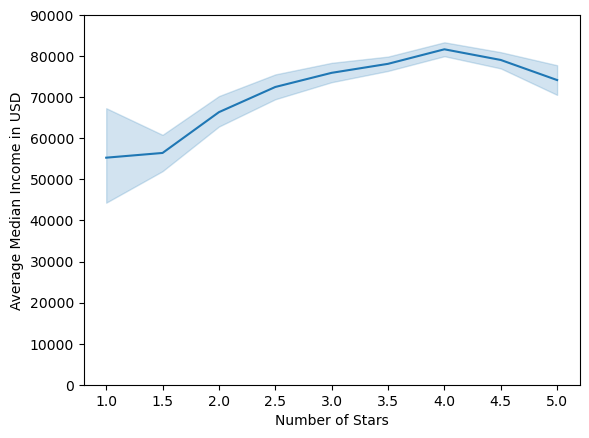

In [18]:

fig,ax = plt.subplots()
sns.lineplot(data=restaurant_join,x='stars',y='B19013_001E')
ax.set_ylim(0,90000)
ax.set_ylabel("Average Median Income in USD")
ax.set_xlabel("Number of Stars")

plt.show()

## 2. Fast food trends in Philadelphia

At the end of part 1, you should have seen a strong trend where higher income tracts generally had restaurants with better reviews. In this section, we'll explore the impact of fast food restaurants and how they might be impacting this trend. 

**Hypothesis**

1. Fast food restaurants are predominantly located in areas with lower median income levels. 
1. Fast food restaurants have worse reviews compared to typical restaurants. 

If true, these two hypotheses could help to explain the trend we found in part 1. Let's dive in and test our hypotheses!

### 2.1 Identify fast food restaurants

The "categories" column in our dataset contains multiple classifications for each restaurant. One such category is "Fast Food". In this step, add a new column called "is_fast_food" that is `True` if the "categories" column contains the term "Fast Food" and `False` otherwise

In [19]:
restaurant_join['is_fast_food'] = restaurant_join['categories'].str.contains('Fast Food')
restaurant_join.head()

,business_id,latitude,longitude,name,review_count,stars,categories,geometry,index_right,STATEFP,...,NAMELSADCO,STATE_NAME,LSAD,ALAND,AWATER,B19013_001E,state,county,tract,is_fast_food
0,MTSW4McQd7CbVtyjqoe9mw,39.955505,-75.155564,St Honore Pastries,80,4.0,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",POINT (-75.15556 39.95551),85,42,...,Philadelphia County,Pennsylvania,CT,386232,0,91067.0,42,101,000200,False
51,L_sXNadtVHjxMw7Yhvkj9Q,39.955454,-75.154900,Naoki Ramen,92,4.0,"Ramen, Restaurants, Japanese",POINT (-75.15490 39.95545),85,42,...,Philadelphia County,Pennsylvania,CT,386232,0,91067.0,42,101,000200,False
95,icp_IKE9zIkAqAucyS1vTA,39.955495,-75.155256,Hakka Beef House,33,4.5,"Restaurants, Chinese",POINT (-75.15526 39.95549),85,42,...,Philadelphia County,Pennsylvania,CT,386232,0,91067.0,42,101,000200,False
114,8cLbpSZOHnmzxzDNSBGQCA,39.955417,-75.155495,About BBQ,14,4.0,"Barbeque, Restaurants",POINT (-75.15549 39.95542),85,42,...,Philadelphia County,Pennsylvania,CT,386232,0,91067.0,42,101,000200,False
154,mCo2uVTTGYrEhRrkQW-CMw,39.953940,-75.156309,Empress Garden,263,4.0,"Taiwanese, Chinese, Noodles, Restaurants",POINT (-75.15631 39.95394),85,42,...,Philadelphia County,Pennsylvania,CT,386232,0,91067.0,42,101,000200,False


### 2.2 Calculate the median income for fast food and otherwise

Group by the "is_fast_food" column and calculate the median income for restaurants that are and are not fast food. You should find that income levels are lower in tracts with fast food.

*Note:* this is just an estimate, since we are calculating a median of median income values.

In [20]:
summarize = restaurant_join.groupby('is_fast_food')[['B19013_001E']].median()
summarize

,B19013_001E
is_fast_food,
False,77686.0
True,55876.0


### 2.3 Load fast food review data

In the rest of part 2, we're going to run a sentiment analysis on the reviews for fast food restaurants. 
The review data for all fast food restaurants identified in part 2.1 is already stored in the `data/` folder. The data is stored as a JSON file and you can use `pandas.read_json` to load it. 

**Notes**

The JSON data is in a "records" format. To load it, you'll need to pass the following keywords: 

- `orient='records'`
- `lines=True`

In [21]:
fast_food = pd.read_json('.\\data\\reviews_philly_fast_food\\reviews_philly_fast_food.json',orient='records',lines=True)

### 2.4 Trim to the most popular fast food restaurants

There's too many reviews to run a sentiment analysis on all of them in a reasonable time. Let's trim our reviews dataset to the most popular fast food restaurants, using the list provided below.

You will need to get the "business_id" values for each of these restaurants from the restaurants data loaded in part 1.3. Then, trim the reviews data to include reviews only for those business IDs.

In [22]:
popular_fast_food = [
    "McDonald's",
    "Wendy's",
    "Subway",
    "Popeyes Louisiana Kitchen",
    "Taco Bell",
    "KFC",
    "Burger King",
]

In [23]:
fast_food2 = fast_food.merge(restaurants[['business_id','name']],how='left',on='business_id')
fast_food2 = fast_food2[fast_food2['name'].isin(popular_fast_food)]
fast_food2.reset_index(inplace=True,drop=True)
fast_food2.head()

,business_id,review_id,stars,text,name
0,kgMEBZG6rjkGeFzPaIM4MQ,E-yGr1OhsUBxNeUVLDVouA,1,I know I shouldn't expect much but everything ...,McDonald's
1,PjknD8uD_0tisZQbomiYoQ,6TqKBa-HDiq2_W_ip2AItA,5,I am only giving 5 stars because the Shamrock ...,McDonald's
2,kgMEBZG6rjkGeFzPaIM4MQ,NGaXI03qbtBLshjfJV4pbQ,3,"Dirty bathrooms and very slow service, but I w...",McDonald's
3,LACylKxImNI29DKUQpWuHw,HHy9yIjW07VHUE6nXVbsVA,3,Burger King is an okay alternative to Mcdonald...,Burger King
4,gq4zw-ru_rkZ2UBIanaZFQ,yMZTK5B_0SAdUXSrIkXrmA,1,ive tried going here four times with no succes...,McDonald's


### 2.5 Run the emotions classifier on fast food reviews

Run a sentiment analysis on the reviews data from the previous step. Use the [DistilBERT model](https://huggingface.co/bhadresh-savani/distilbert-base-uncased-emotion) that can predict emotion labels (anger, fear, sadness, joy, love, and surprise). Transform the result from the classifier into a DataFrame so that you have a column for each of the emotion labels.

In [24]:
from transformers import pipeline

In [25]:
model = 'bhadresh-savani/distilbert-base-uncased-emotion'

sentiment_classifier = pipeline(
    task="sentiment-analysis",  # The task we are doing
    model=model,  # The specific model name
    top_k=None,  # Predict all labels, not just top ones
    tokenizer=model,  # Tokenize inputs using model tokenizer
    truncation=True,  # Truncate text if we need to
)


Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [26]:
review = fast_food2['text'].str.strip().tolist()

In [27]:
emotion_scores = sentiment_classifier(review)

In [28]:
emotion = pd.DataFrame(
    [{d["label"]: d["score"] for d in dd} for dd in emotion_scores]
).assign(text=review)

emotion

,sadness,fear,anger,joy,surprise,love,text
0,0.733871,0.250675,0.011039,0.002758,0.001015,0.000643,I know I shouldn't expect much but everything ...
1,0.000230,0.000126,0.000165,0.998759,0.000246,0.000475,I am only giving 5 stars because the Shamrock ...
2,0.000216,0.000088,0.000153,0.998563,0.000161,0.000819,"Dirty bathrooms and very slow service, but I w..."
3,0.000838,0.000403,0.000811,0.996928,0.000140,0.000880,Burger King is an okay alternative to Mcdonald...
4,0.005284,0.000753,0.006195,0.985421,0.001620,0.000726,ive tried going here four times with no succes...
...,...,...,...,...,...,...,...
2818,0.007423,0.021134,0.008681,0.011282,0.240121,0.711359,Been having a bad run lately with fast food pl...
2819,0.008621,0.223509,0.740585,0.023592,0.001969,0.001723,I came to this location after leaving the airp...
2820,0.001137,0.000907,0.997214,0.000428,0.000129,0.000184,1 star is way more than I would give them. Ord...
2821,0.016490,0.001545,0.979908,0.001422,0.000290,0.000345,This place needs to be shut down!!!\nPlace loo...


### 2.6 Identify the predicted emotion for each text

Use the pandas [idxmax()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.idxmax.html) to identify the predicted emotion for each review, and add this value to a new column called "prediction"

The predicted emotion has the highest confidence score across all emotion labels for a particular label.

In [29]:
emotion['prediction'] = emotion[['sadness','fear','anger','joy','surprise','love']].idxmax(axis=1)

### 2.7 Combine the ratings and sentiment data

Combine the data from part 2.4 (reviews data) and part 2.6 (emotion data). Use the `pd.concat()` function and combine along the column axis.

**Note:** You'll need to reset the index of your reviews data frame so it matches the emotion data index (it should run from 0 to the length of the data - 1).


In [30]:
concat = pd.concat([fast_food2,emotion],axis=1)

### 2.8 Plot sentiment vs. stars

We now have a dataframe with the predicted primary emotion for each review and the associated number of stars for each review. Let's explore two questions:

1. Does sentiment analysis work? Do reviews with fewer stars have negative emotions?
1. For our fast food restaurants, are reviews generally positive or negative? 

Use seaborn's [histplot()](https://seaborn.pydata.org/generated/seaborn.histplot.html) to make a stacked bar chart showing the breakdown of each emotion for each stars category (1 star, 2 stars, etc.). A few notes:

- To stack multiple emotion labels in one bar, use the `multiple="stack"` keyword
- The `discrete=True` can be helpful to tell seaborn our stars values are discrete categories


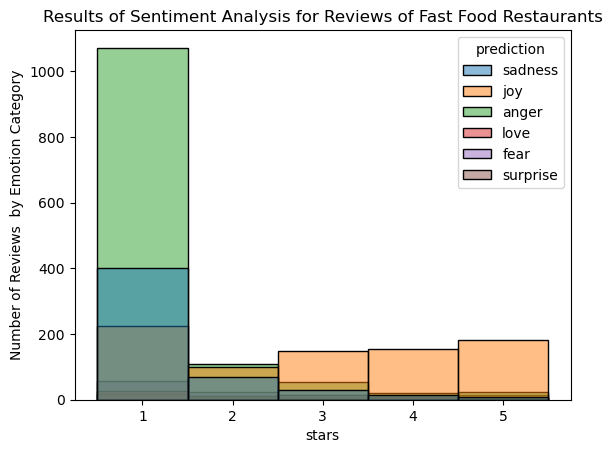

In [31]:
fig,ax = plt.subplots()

sns.histplot(concat,x='stars',stat='count',hue='prediction',discrete=True,binwidth=0.6)

ax.set_ylabel('Number of Reviews  by Emotion Category')
plt.title('Results of Sentiment Analysis for Reviews of Fast Food Restaurants')
plt.show()

**Question:** What does your chart indicate for the effectiveness of our sentiment analysis? Does our original hypothesis about fast food restaurants seem plausible?

The chart indicates that the sentiment analysis is very effective at predicting the sentiment of a review. The reviews which gave 1 star tended to be associated with emotions of sadness, anger, and surprise. On ther other hand, reviews which gave four or five stars tend to be associated with joy. 

The chart supports our hypothesis that Fast food restaurants have worse reviews compared to typical restaurants as most fast food restaurants have one star reviews, and the reviews are associated with negative sentiments. However, to be fully confident that fast food restaurants have worse reviews we would need to produce the same chart for non fast food restaurants.